# 💻 Notebook de Comparação de Pipelines de Machine Learning (Diabetes)

## Objetivo

O objetivo final deste projeto é prever se um paciente possui ou não diabetes com base em alguns dados médicos.

Confeccionamos **dois pipelines distintos de Machine Learning** durante os estudos para entrega do Tech Challenge. Neste notebook, procuraremos explicar a linha de raciocínio que fundamentou as escolhas de cada um dos pipelines e, por fim, concluirmos de forma objetiva qual foi o mais assertivo.

### Estrutura da Comparação dos pipelines:

**Pipeline A (Baseline - MLOps):**
- Abordagem conservadora com preservação máxima dos dados
- Foco em robustez e estabilidade
- Utiliza técnicas clássicas de pré-processamento

**Pipeline B (Otimizado - Deep Dive):**
- Abordagem otimizada com feature engineering avançada
- Foco em maximizar sensibilidade (Recall)
- Incorpora técnicas modernas e ajustes de threshold

### Perguntas a Responder:

1. Qual pipeline oferece melhor capacidade de detecção de diabetes (Recall)?
2. O ganho de performance justifica a complexidade adicional?
3. Quais features são mais importantes para o diagnóstico?
4. Como diferentes estratégias de pré-processamento impactam os resultados?

Ao final, teremos evidências quantitativas para determinar a **abordagem mais eficaz** para este problema de saúde pública.

## 1. Configuração e Funções Comuns

### 1.1 Instalação e Importação de Bibliotecas

Nesta seção, importamos todas as bibliotecas necessárias para ambos os pipelines, garantindo um ambiente consistente para a execução e comparação dos modelos.

**Bibliotecas Principais:**
- **pandas/numpy:** Manipulação e análise de dados
- **scikit-learn:** Algoritmos de ML, pré-processamento e métricas
- **imblearn:** Técnicas de balanceamento (SMOTE)
- **xgboost:** Algoritmo de gradient boosting avançado
- **seaborn/matplotlib:** Visualização de dados
- **shap:** Interpretabilidade de modelos (análise SHAP values)
- **kagglehub:** Download automático do dataset

In [1]:
# Célula 1.1: Instalação (descomente se necessário)
# !pip install pandas numpy scikit-learn matplotlib seaborn imblearn xgboost kagglehub shap

# Célula 1.1: Importações
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
import shap
import xgboost as xgb

# Scikit-learn e Imblearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Configuração para evitar warnings do SHAP
shap.initjs()

print("Todas as bibliotecas e ferramentas foram importadas.")

Todas as bibliotecas e ferramentas foram importadas.


### 1.2 Funções Auxiliares Comuns

Funções compartilhadas por ambos os pipelines para garantir consistência na obtenção e tradução dos dados.

**Funções incluídas:**
- `traduzir_colunas()`: Traduz nomes das colunas para português, facilitando a interpretação
- `carregar_e_salvar_kaggle()`: Baixa o dataset diretamente do Kaggle e salva localmente

**Por que centralizar estas funções?**
- Garante que ambos os pipelines usem exatamente os mesmos dados de entrada
- Facilita manutenção e reduz duplicação de código
- Permite comparação justa entre as abordagens

In [2]:
# Célula 1.2: Funções Auxiliares Comuns

DATASET_HANDLE = 'mathchi/diabetes-data-set'
TARGET_COL = 'Outcome'
DATA_PATH_TEMP = 'temp_data_file.csv' # Nome temporário do arquivo CSV após download

def traduzir_colunas(dados: pd.DataFrame) -> pd.DataFrame:
    '''Traduz os nomes das colunas.'''
    return dados.rename(columns={
        'Pregnancies': 'Gestações',
        'Glucose': 'Glicose',
        'BloodPressure': 'Pressão',
        'SkinThickness': 'Espessura da pele',
        'Insulin': 'Insulina',
        'BMI': 'IMC',
        'DiabetesPedigreeFunction': 'Hereditariedade',
        'Age': 'Idade',
        'Outcome': 'Diagnóstico'
    })

def carregar_e_salvar_kaggle(handle: str, save_path: str) -> pd.DataFrame:
    '''Carrega o dataset do KaggleHub, salva o CSV localmente e retorna o DataFrame.'''
    print(f'Iniciando o carregamento dos dados de: {handle}')
    
    # Baixar e obter o caminho do arquivo
    endereco_de_origem = kagglehub.dataset_download(handle=handle, force_download=True)
    diretorio_de_origem = Path(endereco_de_origem).resolve()
    
    # Encontrar e carregar o CSV
    lista_dados_csv = []
    for item in diretorio_de_origem.iterdir():
        if item.is_file() and item.suffix.lower() == '.csv':
            df = pd.read_csv(item)
            lista_dados_csv.append(df)
            # Salvar em um local conhecido para o Pipeline B usar (se necessário)
            df.to_csv(save_path, index=False)
            print(f"Arquivo CSV salvo temporariamente em '{save_path}'")
            
    if not lista_dados_csv:
        raise FileNotFoundError("Nenhum arquivo CSV encontrado no dataset do Kaggle.")
        
    dados = pd.concat(lista_dados_csv, axis=0, ignore_index=True)
    print('Finalizando o carregamento dos dados\n')
    return dados

# Carregar o dataset para que ambos os pipelines possam utilizá-lo
dados_originais = carregar_e_salvar_kaggle(DATASET_HANDLE, DATA_PATH_TEMP)
print(f"Shape dos dados carregados: {dados_originais.shape}")

Iniciando o carregamento dos dados de: mathchi/diabetes-data-set


100%|██████████| 8.91k/8.91k [00:00<00:00, 960kB/s]

Extracting files...
Arquivo CSV salvo temporariamente em 'temp_data_file.csv'
Finalizando o carregamento dos dados

Shape dos dados carregados: (768, 9)


### 1.3 Análise exploratória dos Dados

// ...existing code...

<VSCode.Cell id="#VSC-c2a3297c" language="markdown">
### 1.3 Análise Exploratória dos Dados

Antes de iniciar os pipelines de machine learning, é fundamental compreender profundamente os dados com os quais estamos trabalhando. Esta análise exploratória nos permite:

**Objetivos da Análise:**
1. **Entender a estrutura** do dataset (dimensões, tipos de dados, valores ausentes)
2. **Identificar padrões** nas distribuições das variáveis
3. **Detectar outliers** e valores biologicamente impossíveis
4. **Analisar correlações** entre features e o diagnóstico de diabetes
5. **Validar decisões de pré-processamento** que serão tomadas nos pipelines

**Por que esta etapa é importante?**
- Decisões de pré-processamento (como remoção de colunas ou tratamento de zeros) devem ser baseadas em evidências
- Compreender a distribuição dos dados ajuda na escolha de métodos de imputação
- Correlações revelam quais features podem ser mais relevantes para o modelo


ANÁLISE EXPLORATÓRIA DO DATASET DE DIABETES

1. ESTRUTURA E INFORMAÇÕES GERAIS

Dimensões do dataset: 768 registros × 9 colunas

Primeiras 5 linhas do dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

----------------------------------------------------------------------
Informações sobre tipos de dados e memória:
---------------------------

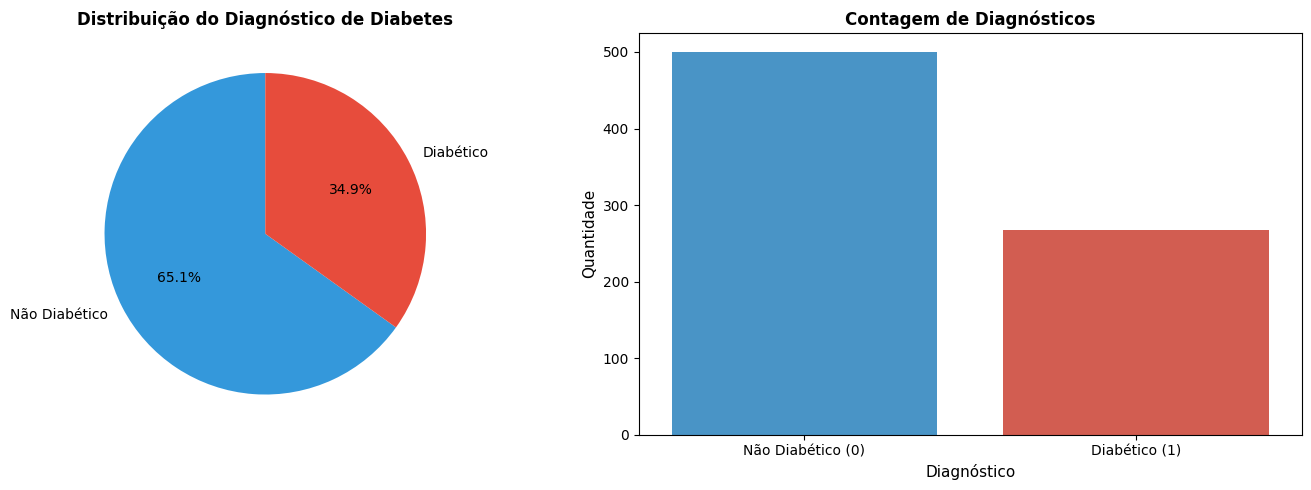


📊 OBSERVAÇÃO:
Dataset DESBALANCEADO: 65.1% não-diabéticos vs 34.9% diabéticos
→ Justifica o uso de SMOTE nos pipelines para balanceamento!

4. DISTRIBUIÇÃO DAS VARIÁVEIS NUMÉRICAS


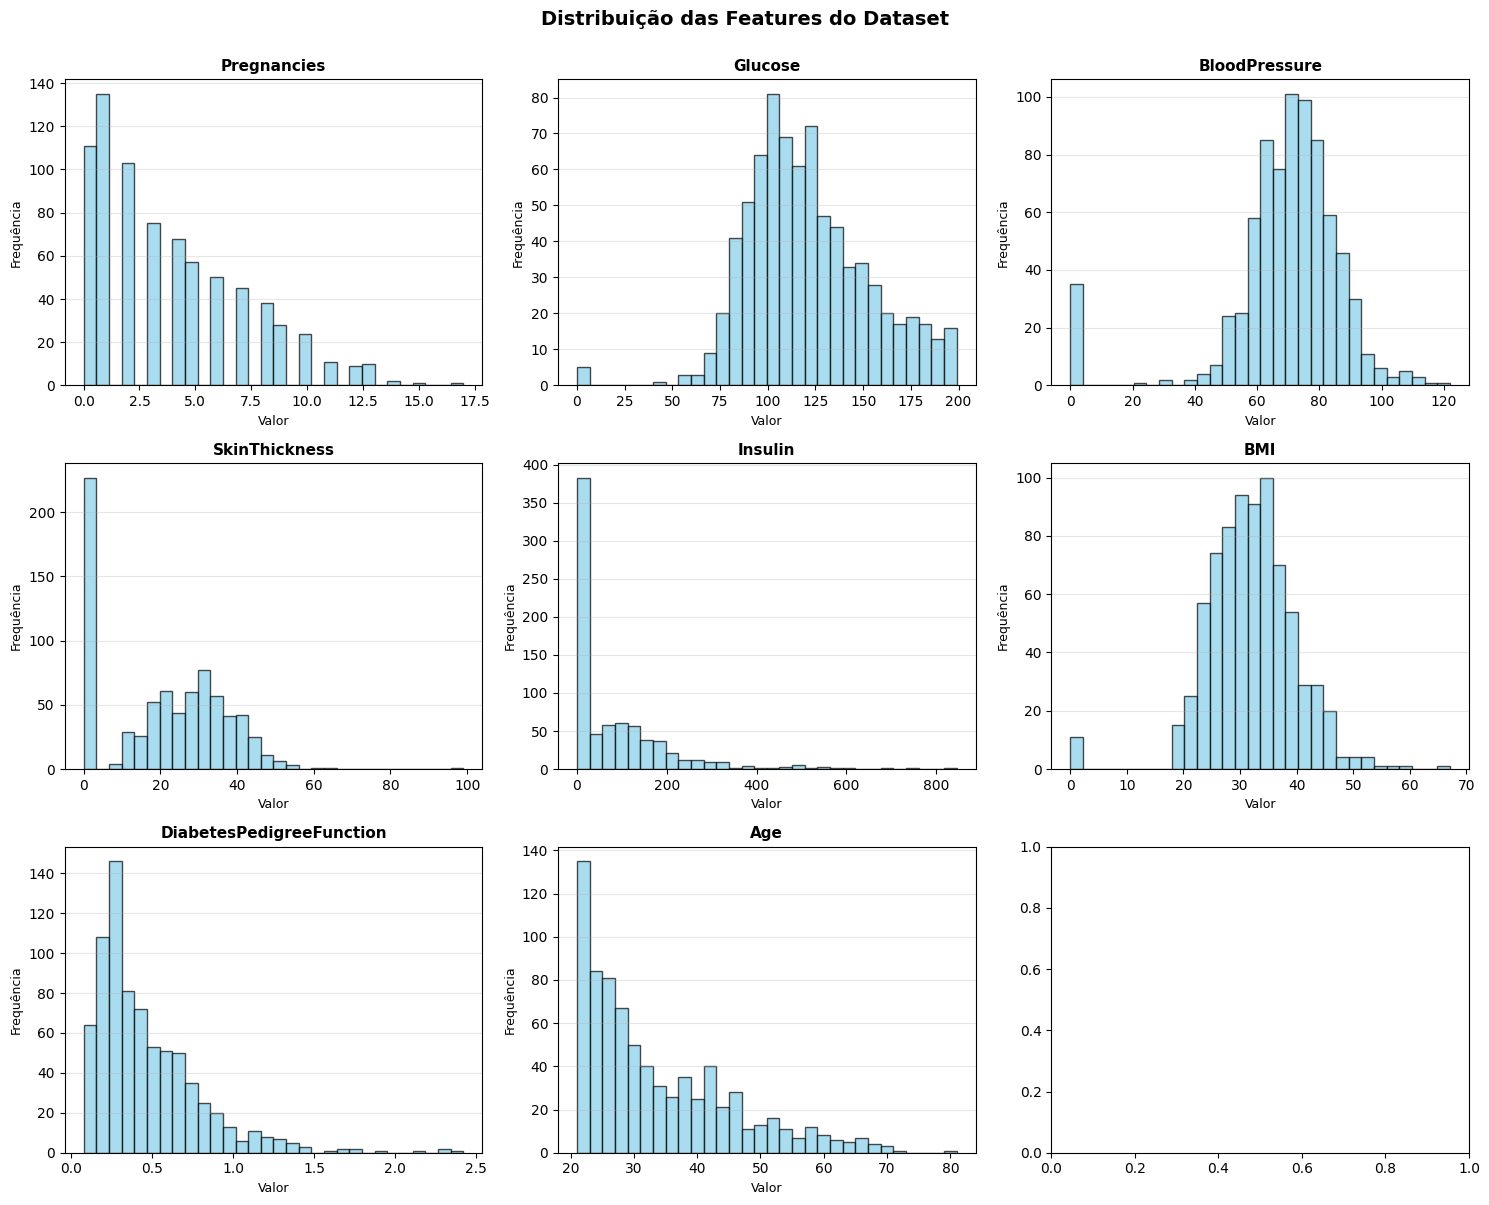


5. ANÁLISE DE OUTLIERS (BOXPLOTS)


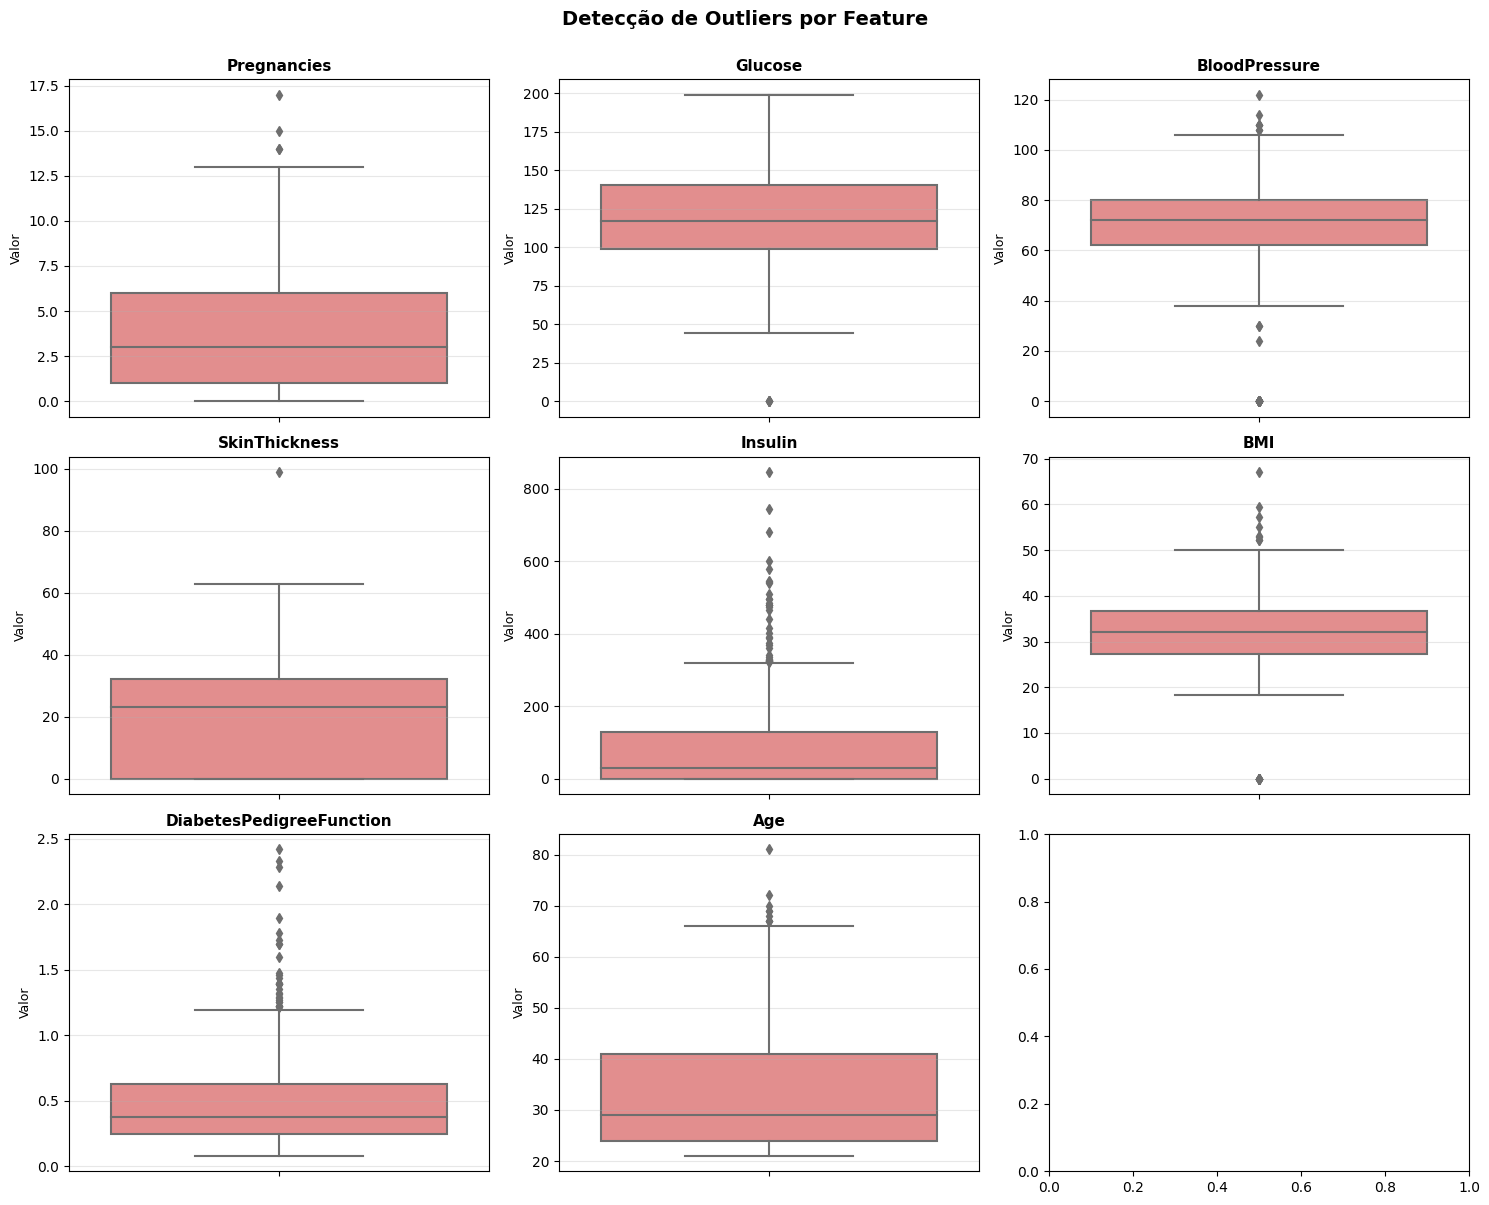


📌 OBSERVAÇÃO:
- Outliers são comuns em dados médicos e podem ser casos legítimos (ex: diabetes severo)
- Por isso, escolhemos RobustScaler (resistente a outliers) ao invés de StandardScaler

6. CORRELAÇÃO ENTRE FEATURES E DIAGNÓSTICO


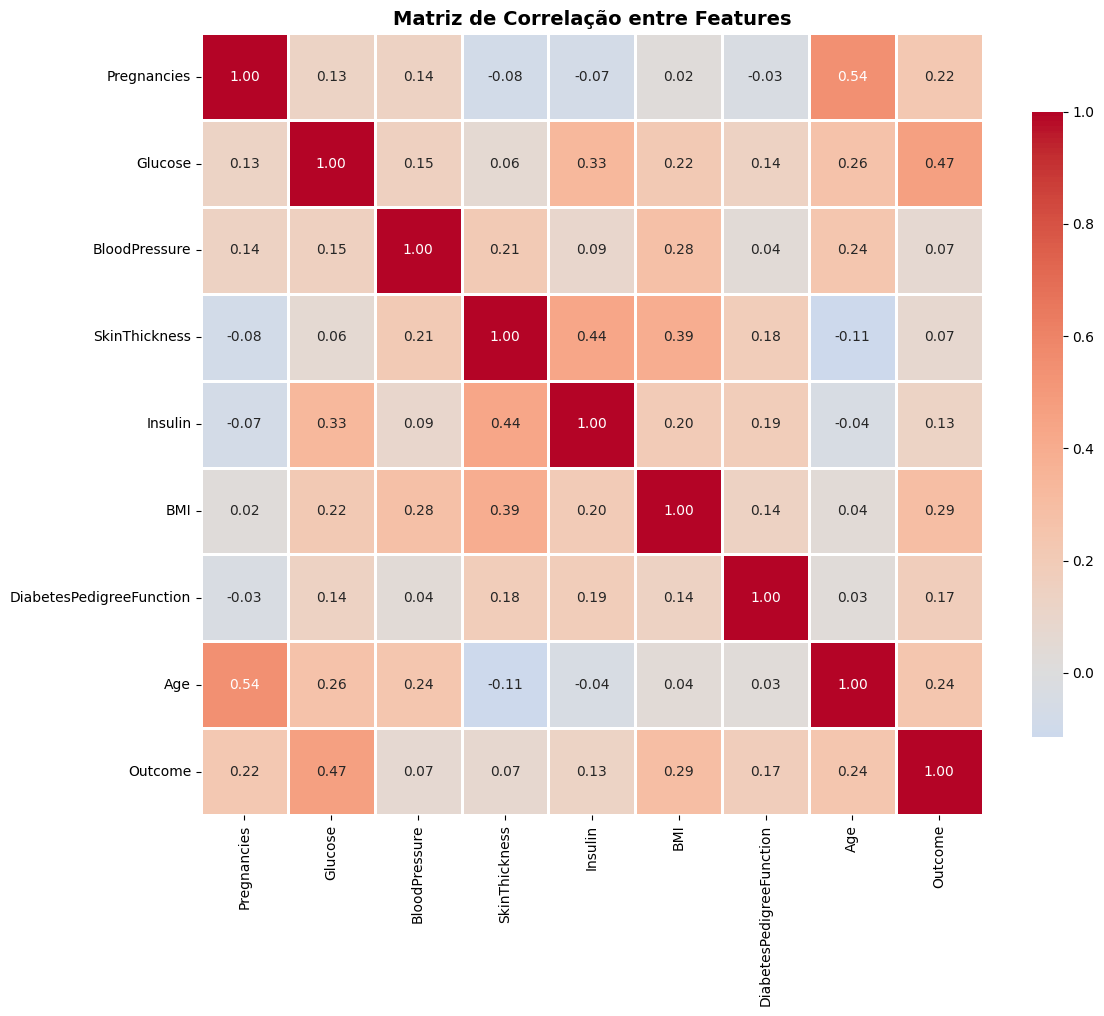


----------------------------------------------------------------------
Ranking de Correlação com o Diagnóstico (Outcome):
----------------------------------------------------------------------
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068

🔍 PRINCIPAIS INSIGHTS:
1. Glucose (0.467): Maior correlação - predictor mais forte!
2. BMI (0.293): Segunda maior correlação
3. Age (0.238): Idade é fator importante


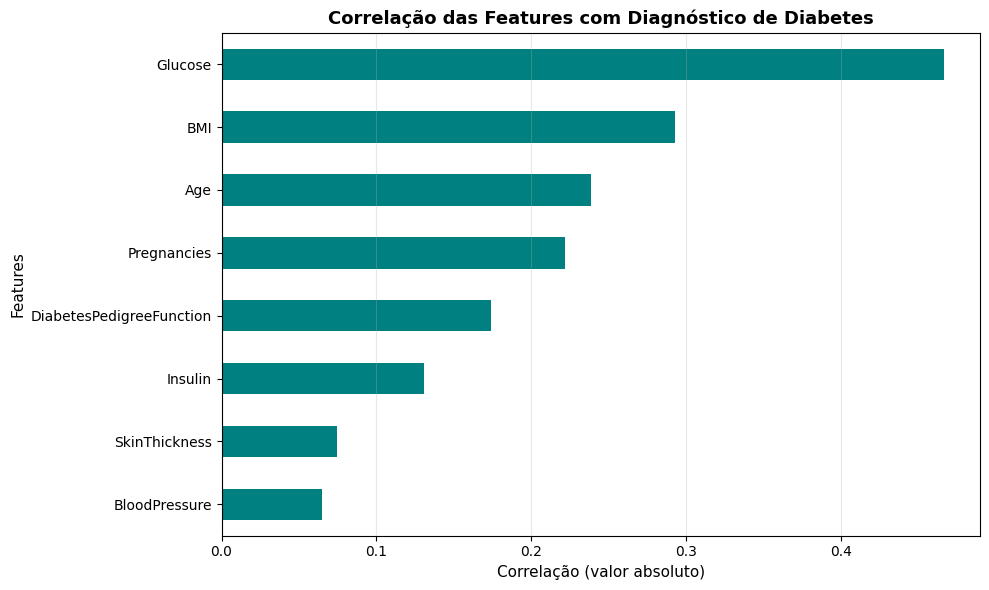


7. ANÁLISE BIVARIADA: FEATURES VS DIAGNÓSTICO

8. RESUMO DA ANÁLISE EXPLORATÓRIA

✅ PRINCIPAIS DESCOBERTAS:

1. QUALIDADE DOS DADOS:
   - Não há valores NaN explícitos
   - Zeros inválidos presentes em várias colunas:
     • Insulin: 48.7% zeros (ALTA taxa - candidata à remoção)
     • SkinThickness: 29.6% zeros (ALTA taxa - candidata à remoção)
     • BloodPressure: 4.5% zeros (tratável por imputação)
     • BMI: 1.4% zeros (tratável por imputação)
     • Glucose: 0.6% zeros (tratável por imputação)

2. DESBALANCEAMENTO:
   - Classes desbalanceadas: 65.1% vs 34.9%
   - Necessário: SMOTE para balanceamento

3. CORRELAÇÕES:
   - Glucose: Maior preditor (r = 0.467)
   - BMI: Segundo preditor (r = 0.293)
   - Age: Terceiro preditor (r = 0.238)

4. OUTLIERS:
   - Presentes em várias features (ex: Insulin, Glucose)
   - São casos médicos legítimos, não erros
   - Justifica uso de RobustScaler (resistente a outliers)

📋 DECISÕES DE PRÉ-PROCESSAMENTO VALIDADAS:
   ✓ Pipeline A: Imputar zeros

In [3]:
# Célula 1.3: Análise Exploratória dos Dados

print("=" * 70)
print("ANÁLISE EXPLORATÓRIA DO DATASET DE DIABETES")
print("=" * 70)

# ============================================================================
# 1. INFORMAÇÕES GERAIS DO DATASET
# ============================================================================
print("\n" + "=" * 70)
print("1. ESTRUTURA E INFORMAÇÕES GERAIS")
print("=" * 70)

print(f"\nDimensões do dataset: {dados_originais.shape[0]} registros × {dados_originais.shape[1]} colunas")
print("\nPrimeiras 5 linhas do dataset:")
print(dados_originais.head())

print("\n" + "-" * 70)
print("Informações sobre tipos de dados e memória:")
print("-" * 70)
dados_originais.info()

print("\n" + "-" * 70)
print("Estatísticas descritivas:")
print("-" * 70)
print(dados_originais.describe().round(2))

# ============================================================================
# 2. ANÁLISE DE VALORES AUSENTES E ZEROS INVÁLIDOS
# ============================================================================
print("\n" + "=" * 70)
print("2. VALORES AUSENTES E ZEROS BIOLOGICAMENTE IMPOSSÍVEIS")
print("=" * 70)

# Verificar NaNs explícitos
print("\nValores NaN explícitos por coluna:")
nan_counts = dados_originais.isnull().sum()
print(nan_counts)

# Analisar zeros que são biologicamente impossíveis
print("\n" + "-" * 70)
print("Análise de ZEROS (potencialmente inválidos):")
print("-" * 70)

colunas_com_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zeros_analysis = pd.DataFrame({
    'Coluna': colunas_com_zeros,
    'Zeros': [dados_originais[col].eq(0).sum() for col in colunas_com_zeros],
    'Percentual (%)': [(dados_originais[col].eq(0).sum() / len(dados_originais) * 100).round(2) 
                       for col in colunas_com_zeros]
})
print(zeros_analysis.to_string(index=False))

print("\n⚠️ INTERPRETAÇÃO:")
print("- Glucose = 0: Biologicamente IMPOSSÍVEL (5 casos)")
print("- BloodPressure = 0: Biologicamente IMPOSSÍVEL (35 casos)")
print("- SkinThickness = 0: Provavelmente inválido (227 casos = 29.6%)")
print("- Insulin = 0: Provavelmente inválido (374 casos = 48.7%)")
print("- BMI = 0: Biologicamente IMPOSSÍVEL (11 casos)")

# ============================================================================
# 3. DISTRIBUIÇÃO DA VARIÁVEL ALVO (OUTCOME)
# ============================================================================
print("\n" + "=" * 70)
print("3. DISTRIBUIÇÃO DO DIAGNÓSTICO (VARIÁVEL ALVO)")
print("=" * 70)

outcome_counts = dados_originais['Outcome'].value_counts()
outcome_pct = dados_originais['Outcome'].value_counts(normalize=True) * 100

print(f"\nDistribuição de classes:")
print(f"- Não Diabético (0): {outcome_counts[0]} casos ({outcome_pct[0]:.2f}%)")
print(f"- Diabético (1): {outcome_counts[1]} casos ({outcome_pct[1]:.2f}%)")

# Gráfico de pizza da distribuição do diagnóstico
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pizza chart
axes[0].pie(outcome_counts, labels=['Não Diabético', 'Diabético'], 
           autopct='%1.1f%%', startangle=90, colors=['#3498db', '#e74c3c'])
axes[0].set_title('Distribuição do Diagnóstico de Diabetes', fontsize=12, fontweight='bold')

# Bar chart
sns.countplot(x='Outcome', data=dados_originais, palette=['#3498db', '#e74c3c'], ax=axes[1], hue='Outcome')
axes[1].set_xlabel('Diagnóstico', fontsize=11)
axes[1].set_ylabel('Quantidade', fontsize=11)
axes[1].set_title('Contagem de Diagnósticos', fontsize=12, fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Não Diabético (0)', 'Diabético (1)'])

plt.tight_layout()
plt.show()

print("\n📊 OBSERVAÇÃO:")
print(f"Dataset DESBALANCEADO: {outcome_pct[0]:.1f}% não-diabéticos vs {outcome_pct[1]:.1f}% diabéticos")
print("→ Justifica o uso de SMOTE nos pipelines para balanceamento!")

# ============================================================================
# 4. DISTRIBUIÇÃO DAS FEATURES NUMÉRICAS
# ============================================================================
print("\n" + "=" * 70)
print("4. DISTRIBUIÇÃO DAS VARIÁVEIS NUMÉRICAS")
print("=" * 70)

# Histogramas de todas as features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(dados_originais.columns[:-1]):  # Exclui Outcome
    axes[idx].hist(dados_originais[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Valor', fontsize=9)
    axes[idx].set_ylabel('Frequência', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Distribuição das Features do Dataset', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================================
# 5. BOXPLOTS PARA IDENTIFICAÇÃO DE OUTLIERS
# ============================================================================
print("\n" + "=" * 70)
print("5. ANÁLISE DE OUTLIERS (BOXPLOTS)")
print("=" * 70)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(dados_originais.columns[:-1]):
    sns.boxplot(y=dados_originais[col], color='lightcoral', ax=axes[idx])
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Detecção de Outliers por Feature', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n📌 OBSERVAÇÃO:")
print("- Outliers são comuns em dados médicos e podem ser casos legítimos (ex: diabetes severo)")
print("- Por isso, escolhemos RobustScaler (resistente a outliers) ao invés de StandardScaler")

# ============================================================================
# 6. MATRIZ DE CORRELAÇÃO
# ============================================================================
print("\n" + "=" * 70)
print("6. CORRELAÇÃO ENTRE FEATURES E DIAGNÓSTICO")
print("=" * 70)

# Calcular matriz de correlação
corr_matrix = dados_originais.corr()

# Heatmap da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Ranking de correlação com Outcome
print("\n" + "-" * 70)
print("Ranking de Correlação com o Diagnóstico (Outcome):")
print("-" * 70)

correlacao_outcome = corr_matrix['Outcome'].drop('Outcome').abs().sort_values(ascending=False)
print(correlacao_outcome.to_string())

print("\n🔍 PRINCIPAIS INSIGHTS:")
print(f"1. Glucose ({correlacao_outcome.iloc[0]:.3f}): Maior correlação - predictor mais forte!")
print(f"2. BMI ({correlacao_outcome.iloc[1]:.3f}): Segunda maior correlação")
print(f"3. Age ({correlacao_outcome.iloc[2]:.3f}): Idade é fator importante")

# Visualizar correlação específica com Outcome
plt.figure(figsize=(10, 6))
correlacao_outcome.sort_values().plot(kind='barh', color='teal')
plt.title('Correlação das Features com Diagnóstico de Diabetes', fontsize=13, fontweight='bold')
plt.xlabel('Correlação (valor absoluto)', fontsize=11)
plt.ylabel('Features', fontsize=11)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 7. ANÁLISE BIVARIADA: FEATURES VS OUTCOME
# ============================================================================
print("\n" + "=" * 70)
print("7. ANÁLISE BIVARIADA: FEATURES VS DIAGNÓSTICO")
print("=" * 70)

# ============================================================================
# 8. RESUMO E CONCLUSÕES DA EDA
# ============================================================================
print("\n" + "=" * 70)
print("8. RESUMO DA ANÁLISE EXPLORATÓRIA")
print("=" * 70)

print("\n✅ PRINCIPAIS DESCOBERTAS:")
print("\n1. QUALIDADE DOS DADOS:")
print("   - Não há valores NaN explícitos")
print("   - Zeros inválidos presentes em várias colunas:")
print("     • Insulin: 48.7% zeros (ALTA taxa - candidata à remoção)")
print("     • SkinThickness: 29.6% zeros (ALTA taxa - candidata à remoção)")
print("     • BloodPressure: 4.5% zeros (tratável por imputação)")
print("     • BMI: 1.4% zeros (tratável por imputação)")
print("     • Glucose: 0.6% zeros (tratável por imputação)")

print("\n2. DESBALANCEAMENTO:")
print(f"   - Classes desbalanceadas: {outcome_pct[0]:.1f}% vs {outcome_pct[1]:.1f}%")
print("   - Necessário: SMOTE para balanceamento")

print("\n3. CORRELAÇÕES:")
print(f"   - Glucose: Maior preditor (r = {corr_matrix.loc['Glucose', 'Outcome']:.3f})")
print(f"   - BMI: Segundo preditor (r = {corr_matrix.loc['BMI', 'Outcome']:.3f})")
print(f"   - Age: Terceiro preditor (r = {corr_matrix.loc['Age', 'Outcome']:.3f})")

print("\n4. OUTLIERS:")
print("   - Presentes em várias features (ex: Insulin, Glucose)")
print("   - São casos médicos legítimos, não erros")
print("   - Justifica uso de RobustScaler (resistente a outliers)")

print("\n📋 DECISÕES DE PRÉ-PROCESSAMENTO VALIDADAS:")
print("   ✓ Pipeline A: Imputar zeros com KNN (preserva todas as features)")
print("   ✓ Pipeline B: Remover Insulin e SkinThickness (>30% ausentes)")
print("   ✓ Ambos: Usar RobustScaler (outliers legítimos)")
print("   ✓ Ambos: Aplicar SMOTE (desbalanceamento)")

print("\n" + "=" * 70)
print("FIM DA ANÁLISE EXPLORATÓRIA")
print("=" * 70 + "\n")

## 2. Execução do Pipeline A (Modelo MLOps - Baseline)

Este pipeline representa uma abordagem **robusta e conservadora** de pré-processamento, priorizando a integridade dos dados e a diversidade de modelos.

### Características Principais do Pipeline A:

**1. Estratégia de Imputação:**
- Utiliza **KNN Imputer (k=5)** para tratar valores ausentes
- **Por quê?** Este método considera a similaridade entre registros, preservando padrões locais nos dados
- Valores faltantes são estimados com base nos 5 vizinhos mais próximos.

**2. Normalização:**
- Aplica **RobustScaler** para padronização
- **Por quê?** Este método é resistente a outliers, usando mediana e IQR (Intervalo Interquartil)
- Em dados médicos, outliers podem ser casos legítimos (ex: diabetes severo), não erros a serem descartados

**3. Balanceamento:**
- Usa **SMOTE** (Synthetic Minority Over-sampling Technique)
- **Por quê?** O dataset possui desbalanceamento entre casos diabéticos e não-diabéticos
- SMOTE cria exemplos sintéticos da classe minoritária, melhorando a capacidade do modelo de detectar diabetes

**4. Conjunto de Modelos:**
- Logistic Regression, Decision Tree, KNeighbors e Random Forest
- **Por quê?** Diversidade de algoritmos permite comparar diferentes abordagens: linear, baseada em árvores, e baseada em distância
- Todos configurados com `class_weight='balanced'` para lidar com o desbalanceamento

**5. Critério de Avaliação:**
- Foco em **Recall (Sensibilidade)**
- **Por quê?** No diagnóstico médico, é mais crítico **não perder casos positivos** (evitar falsos negativos)
- Preferimos identificar todos os possíveis diabéticos, mesmo que isso gere alguns falsos alarmes

### 2.1 Funções Exclusivas do Pipeline A

In [4]:
# Célula 2.1: Funções Exclusivas do Pipeline A

def separar_A(dados: pd.DataFrame, target: str):
    '''Separa features e alvo, e divide em treino e teste (80/20 estratificado).'''
    X_dados = dados.drop(columns=[target], axis=1)
    y_dados = dados[target]
    return train_test_split(X_dados, y_dados, test_size=0.2, random_state=42, stratify=y_dados)

def imputar_A(X_treino: pd.DataFrame, X_teste: pd.DataFrame):
    '''Substitui zeros inválidos por NaN e usa KNNImputer (k=5).'''
    print('Iniciando a imputação dos dados (KNN)')
    colunas_invalidas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
    X_treino[colunas_invalidas] = X_treino[colunas_invalidas].replace(0, np.nan)
    X_teste[colunas_invalidas] = X_teste[colunas_invalidas].replace(0, np.nan)
    imputer = KNNImputer(n_neighbors=5)
    
    # Usando .copy() para garantir que a transformação não afete o DataFrame original global
    X_treino_imputado = pd.DataFrame(imputer.fit_transform(X_treino), columns=X_treino.columns, index=X_treino.index)
    X_teste_imputado = pd.DataFrame(imputer.transform(X_teste), columns=X_teste.columns, index=X_teste.index)
    
    print('Finalizando a imputação dos dados\n')
    return X_treino_imputado, X_teste_imputado

def balancear_A(X_treino: pd.DataFrame, y_treino: pd.DataFrame):
    '''Equilibra a quantidade de dados por diagnóstico usando SMOTE.'''
    print('Iniciando o balanceamento dos dados (SMOTE)')
    X_treino_balanceado, y_treino_balanceado = SMOTE(random_state=42).fit_resample(X_treino, y_treino)
    print(f'Finalizando o balanceamento dos dados. Novos positivos: {y_treino_balanceado.sum()}\n')
    return X_treino_balanceado, y_treino_balanceado

def padronizar_A(X_treino: pd.DataFrame, X_teste: pd.DataFrame):
    '''Aplica padronização nas colunas usando RobustScaler.'''
    print('Iniciando o escalonamento dos dados (RobustScaler)')
    scaler = RobustScaler()
    X_treino_padronizado = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns, index=X_treino.index)
    X_teste_padronizado = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns, index=X_teste.index)
    print('Finalizando o escalonamento dos dados\n')
    return X_treino_padronizado, X_teste_padronizado

def criar_modelos_A():
    '''Gera uma lista de instâncias de modelos para avaliação.'''
    return {
        'Logistic Regression (A)': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'Decision Tree (A)': DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=42),
        'KNeighbors (A)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'Random Forest (A)': RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
    }

def avaliar_A(modelos, X_teste, y_teste):
    '''Avalia modelos e retorna o de melhor Recall, coletando os resultados.'''
    print('Iniciando a avaliação dos modelos do Pipeline A')
    resultados = []
    
    for nome, modelo in modelos.items():
        y_previsto = modelo.predict(X_teste)
        
        resultados.append({
            'Pipeline': 'A',
            'Modelo': nome,
            'Precision': precision_score(y_teste, y_previsto, zero_division=0),
            'Recall': recall_score(y_teste, y_previsto, zero_division=0),
            'F1-score': f1_score(y_teste, y_previsto, zero_division=0),
        })
        print(f'\n--- Classificação do modelo {nome} ---')
        print(classification_report(y_teste, y_previsto, zero_division=0))

    df_resultados = pd.DataFrame(resultados)
    
    melhor_modelo_df = df_resultados.loc[df_resultados['Recall'].idxmax()]
    nome_melhor_modelo = melhor_modelo_df['Modelo']
    melhor_modelo = modelos[nome_melhor_modelo]
    
    print(f'\nMelhor modelo (baseado em Recall): {nome_melhor_modelo}')
    return melhor_modelo, df_resultados

def treinar_A(modelos, X_treino, y_treino):
    '''Treina uma lista de modelos.'''
    print('Iniciando o treino dos modelos do Pipeline A')
    for modelo in modelos.values():
        modelo.fit(X_treino, y_treino)
    print('Finalizando o treino dos modelos\n')
    return modelos

### 2.2 Execução do Fluxo A

Nesta célula, executamos o **pipeline completo do modelo baseline**, seguindo a sequência:

1. **Separação treino/teste** (80/20) com estratificação para manter proporção de classes
2. **Imputação** usando KNN (k=5) para preencher valores ausentes
3. **Balanceamento** com SMOTE para equilibrar classes
4. **Padronização** com RobustScaler (resistente a outliers)
5. **Treinamento** de múltiplos modelos (LogReg, DT, RF, KNN)
6. **Avaliação** focada em Recall (sensibilidade)

**Resultado esperado:**
Métricas de desempenho de todos os modelos e identificação do melhor modelo baseado em Recall.

In [5]:
# Célula 2.2: Fluxo Principal do Pipeline A

print('=============================================')
print('=== EXECUTANDO O PIPELINE A (BASELINE) ===')
print('=============================================\n')

dados_A = dados_originais.copy()

# 1. Separar Treino/Teste
X_treino_A, X_teste_A, y_treino_A, y_teste_A = separar_A(dados_A, TARGET_COL)

# 2. Imputação (KNN Imputer)
X_treino_imputado_A, X_teste_imputado_A = imputar_A(X_treino_A.copy(), X_teste_A.copy())

# 3. Balanceamento (SMOTE)
X_treino_base_A, y_treino_base_A = balancear_A(X_treino_imputado_A, y_treino_A)

# 4. Padronização (RobustScaler)
X_treino_padronizado_A, X_teste_padronizado_A = padronizar_A(X_treino_base_A, X_teste_imputado_A)
feat_names_A = X_treino_padronizado_A.columns.tolist()

# 5. Modelagem e Treinamento
modelos_A = criar_modelos_A()
modelos_treinados_A = treinar_A(modelos_A, X_treino_padronizado_A, y_treino_base_A)

# 6. Avaliação e Coleta de Resultados
melhor_modelo_A, resultados_A = avaliar_A(modelos_treinados_A, X_teste_padronizado_A, y_teste_A)

print('\n=============================================')
print(f'RESULTADOS FINAIS DO PIPELINE A COLETADOS.')
print('=============================================\n')

=== EXECUTANDO O PIPELINE A (BASELINE) ===

Iniciando a imputação dos dados (KNN)
Finalizando a imputação dos dados

Iniciando o balanceamento dos dados (SMOTE)
Finalizando o balanceamento dos dados. Novos positivos: 400

Iniciando o escalonamento dos dados (RobustScaler)
Finalizando o escalonamento dos dados

Iniciando o treino dos modelos do Pipeline A
Finalizando o treino dos modelos

Iniciando a avaliação dos modelos do Pipeline A

--- Classificação do modelo Logistic Regression (A) ---
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.61      0.72      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154


--- Classificação do modelo Decision Tree (A) ---
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       100
           1     

## 3. Execução do Pipeline B (Otimizado/Deep Dive)

Este pipeline representa uma abordagem **otimizada e focada**, com pré-processamento mais agressivo e técnicas avançadas de modelagem.

### Características Principais do Pipeline B:

**1. Limpeza de Features:**
- **Remove colunas problemáticas:** SkinThickness (30% ausentes) e Insulin (48% ausentes)
- **Por quê?** Quando mais de 40% dos dados estão ausentes, imputar se torna "inventar" mais dados do que observar
- Decisão baseada no princípio: **qualidade sobre quantidade** - melhor ter menos features confiáveis

**2. Estratégia de Imputação:**
- Utiliza **SimpleImputer com mediana** (não KNN)
- **Por quê?** Mais simples e eficiente, apropriado quando há poucas colunas a imputar
- Após remover as colunas problemáticas, apenas ~6% dos dados precisam ser imputados

**3. Feature Engineering:**
- **Cria variáveis derivadas** que capturam interações e padrões de risco:
  - `idade_maior_45`: Flag binário (Age ≥ 45), pois risco de diabetes aumenta com idade
  - `imc_obeso`: Flag binário (BMI ≥ 30), obesidade é fator de risco conhecido
  - `idade_bmi`: Interação (Age × BMI), captura risco combinado
  - `glucose_bmi`: Interação (Glucose × BMI), relaciona metabolismo com composição corporal

**Por quê criar estas variáveis?**
- Modelos de ML podem ter dificuldade em capturar relações não-lineares automaticamente
- Feature Engineering **explicita** relações que sabemos serem importantes do domínio médico
- Exemplo: Uma pessoa de 50 anos com BMI 35 tem risco MAIOR que a soma isolada das partes

**4. Modelos Adicionais:**
- Inclui **XGBoost** além dos modelos clássicos
- **Por quê?** XGBoost é bem visto pela comunidade para dados tabulares, frequentemente superando outros algoritmos
- Lida bem com interações complexas entre features

**5. Threshold Ajustado:**
- Usa **threshold de 0.3** (ao invés do padrão 0.5) para classificação
- **Por quê?** Threshold mais baixo significa que o modelo classifica como "diabético" com menos certeza
- **Consequência:** Aumenta Recall (captura mais casos positivos), mas pode reduzir Precision
- **Justificativa médica:** Preferimos encaminhar mais pacientes para exames adicionais do que perder um caso real

### Comparação Pipeline A vs B:

| Aspecto | Pipeline A (Baseline) | Pipeline B (Otimizado) |
|---------|----------------------|------------------------|
| **Filosofia** | Preservar dados originais | Otimizar features |
| **Imputação** | KNN (complexa) | Mediana (simples) |
| **Colunas** | Todas (9) | Reduzidas (7) + 4 novas |
| **Threshold** | 0.5 (padrão) | 0.3 (ajustado) |
| **Foco** | Robustez | Performance (Recall) |

### Estratégia do Pipeline B

Este pipeline adota uma filosofia diferente: **otimização agressiva** baseada em conhecimento do domínio médico.

**Principais diferenças em relação ao Pipeline A:**

1. **Remoção de dados ruidosos** ao invés de imputação complexa
2. **Criação explícita de interações** entre variáveis (feature engineering)
3. **Threshold customizado** (0.3) para priorizar detecção sobre precisão
4. **Inclusão de XGBoost** - algoritmo mais moderno e poderoso

**Hipótese a testar:**
Menos dados de melhor qualidade + features derivadas + threshold otimizado = **maior sensibilidade diagnóstica**

### 3.1 Funções Exclusivas do Pipeline B

In [6]:
# Célula 3.1: Funções Exclusivas do Pipeline B

def split_and_oversample(X, y, test_size=0.2, random_state=42, stratify=True, smote_random_state=42):
    """
    Faz split dos dados em treino/teste e aplica SMOTE apenas nos dados de treino.

    Parâmetros:
        X (array ou DataFrame): Features já processadas/escaladas.
        y (array ou Series): Labels/variável alvo.
        test_size (float): Proporção de teste.
        random_state (int): Semente para reprodutibilidade.
        stratify (bool): Se True, faz stratify em y.
        smote_random_state (int): Semente do SMOTE.

    Retorna:
        X_train_res, X_test, y_train_res, y_test
    """
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )

    smote = SMOTE(random_state=smote_random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    return X_train_res, X_test, y_train_res, y_test

def preprocess_diabetes_data_B(df: pd.DataFrame):
    """
    Pré-processamento:
    - Remove SkinThickness e Insulin
    - Trata zeros em Glucose, BloodPressure, BMI (converte para NaN e imputa mediana)
    - Feature engineering: cria variáveis de risco
    """
    df = df.copy() 
    
    # 1. Remove colunas
    df = df.drop(['SkinThickness', 'Insulin'], axis=1)
    
    # 2. Trata zeros biologicamente impossíveis (SimpleImputer Mediana)
    cols_to_treat = ['Glucose', 'BloodPressure', 'BMI']
    for col in cols_to_treat:
        df[col] = df[col].replace(0, np.nan)
        
    imputer = SimpleImputer(strategy='median')
    df[cols_to_treat] = imputer.fit_transform(df[cols_to_treat])

    # 3. FEATURE ENGINEERING: Variáveis de risco
    df['idade_maior_45'] = (df['Age'] >= 45).astype(int)
    df['imc_obeso'] = (df['BMI'] >= 30).astype(int)
    df['idade_bmi'] = df['Age'] * df['BMI']
    df['glucose_bmi'] = df['Glucose'] * df['BMI']

    # 4. Separa features e target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome'].values
    feat_names = X.columns.tolist()

    # 5. Scaling (RobustScaler - Ajustado para o fluxo do notebook)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feat_names, index=X.index)
    
    return X_scaled_df, y, feat_names

def get_models():
    """
    Cria e retorna dicionário com modelos de classificação configurados para melhor recall.
    """    
    return {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=1, eval_metric='logloss', random_state=42)
    }

def train_models(models, X_train, y_train):
    for model in models.values():
        model.fit(X_train.values, y_train)
    return models

def evaluate_models(models, X_test, y_test, feat_names, threshold=0.3):
    """
    Avalia múltiplos modelos de classificação, exibe métricas e matriz de confusão,
    e retorna o modelo com o melhor Recall.
    """
    best_recall = -1
    best_f1 = -1
    best_model_name = None
    best_model = None
    results = []

    for name, model in models.items():

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
        else:
            y_pred = model.predict(X_test)
            
        current_recall = recall_score(y_test, y_pred)
        current_f1 = f1_score(y_test, y_pred)
        current_precision = precision_score(y_test, y_pred, zero_division=0)

        results.append({
            'Pipeline': 'B',
            'Modelo': name,
            'Precision': current_precision,
            'Recall': current_recall,
            'F1-score': current_f1,
        })
        
        # Lógica de rastreamento do melhor modelo (Baseado no Recall)
        if current_recall > best_recall:
            best_recall = current_recall
            best_f1 = current_f1 
            best_model_name = name
            best_model = model

        print(f"\n--- {name} ---")
        print(f"Recall (Sensibilidade): {current_recall:.2f}")
        print(f"F1-score: {current_f1:.2f}")
        print("\nRelatório de classificação detalhado:")
        print(classification_report(y_test, y_pred))
        print("Matriz de Confusão (linhas = real, colunas = predito):")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão - {name} (Threshold={threshold})')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

    print("==================================================")
    print(f"🏆 Melhor Modelo Encontrado ({best_model_name})")
    print(f"   Critério de Seleção: Maior Recall")
    print(f"   Recall (Sensibilidade): {best_recall:.2f}")
    print(f"   F1-score: {best_f1:.2f}")
    print("==================================================")

    df_results = pd.DataFrame(results)
    
    return best_model, df_results, best_model_name

### 3.2 Execução do Fluxo B

Nesta célula, executamos o **pipeline otimizado**, seguindo a sequência:

1. **Pré-processamento avançado:**
   - Remoção de colunas problemáticas (SkinThickness, Insulin)
   - Imputação simples com mediana
   - Feature engineering (criação de 4 novas variáveis)
   
2. **Split e balanceamento** (80/20) com SMOTE

3. **Treinamento** de múltiplos modelos, incluindo XGBoost

4. **Avaliação** com threshold ajustado (0.3) para aumentar sensibilidade

**Diferencial do Pipeline B:**
- Menos features (7 originais) + 4 features derivadas
- Threshold personalizado para maximizar detecção de casos positivos
- Modelo XGBoost para capturar interações complexas

**Resultado esperado:**
Métricas otimizadas com foco em maximizar Recall, mesmo que isso implique em redução de Precision.

=== EXECUTANDO O PIPELINE B (OTIMIZADO/DEEP DIVE) ===


--- Logistic Regression ---
Recall (Sensibilidade): 0.85
F1-score: 0.63

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       100
           1       0.51      0.85      0.63        54

    accuracy                           0.66       154
   macro avg       0.69      0.70      0.65       154
weighted avg       0.74      0.66      0.66       154

Matriz de Confusão (linhas = real, colunas = predito):


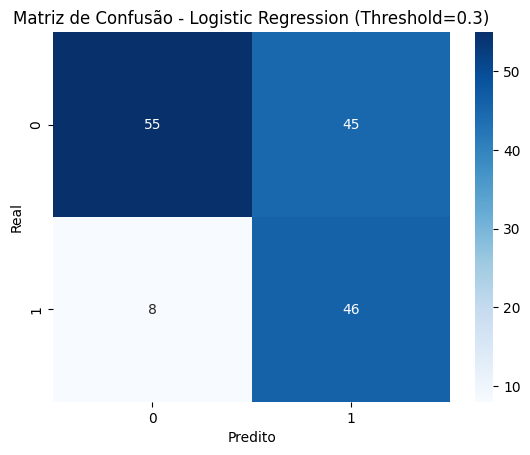


--- Decision Tree ---
Recall (Sensibilidade): 0.56
F1-score: 0.56

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       100
           1       0.56      0.56      0.56        54

    accuracy                           0.69       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.69      0.69      0.69       154

Matriz de Confusão (linhas = real, colunas = predito):


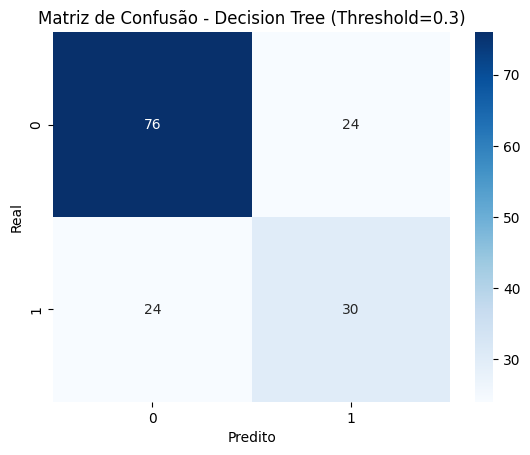


--- Random Forest ---
Recall (Sensibilidade): 0.91
F1-score: 0.72

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       100
           1       0.59      0.91      0.72        54

    accuracy                           0.75       154
   macro avg       0.76      0.78      0.74       154
weighted avg       0.81      0.75      0.75       154

Matriz de Confusão (linhas = real, colunas = predito):


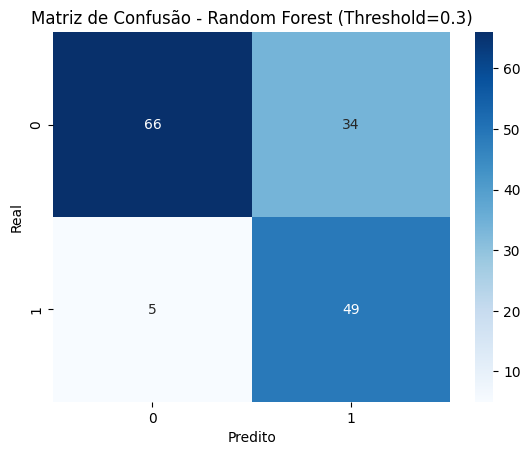


--- XGBoost ---
Recall (Sensibilidade): 0.76
F1-score: 0.67

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       100
           1       0.60      0.76      0.67        54

    accuracy                           0.74       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.74      0.75       154

Matriz de Confusão (linhas = real, colunas = predito):


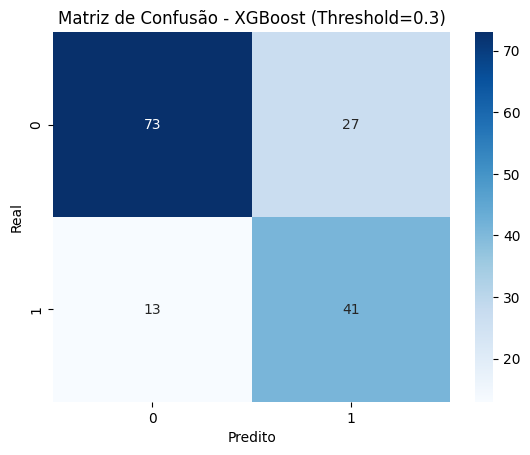

🏆 Melhor Modelo Encontrado (Random Forest)
   Critério de Seleção: Maior Recall
   Recall (Sensibilidade): 0.91
   F1-score: 0.72

RESULTADOS FINAIS DO PIPELINE B COLETADOS.



In [7]:
# Célula 3.2: Fluxo Principal do Pipeline B

print('==================================================')
print('=== EXECUTANDO O PIPELINE B (OTIMIZADO/DEEP DIVE) ===')
print('==================================================\n')

# 1. Pré-processamento e Feature Engineering
# Carregar os dados do arquivo temporário salvo anteriormente
dados_B = pd.read_csv(DATA_PATH_TEMP) 

X_scaled_B, y_B, feat_names_B = preprocess_diabetes_data_B(dados_B)

# 2. Split e Balanceamento (SMOTE)
X_train_res_B, X_test_B, y_train_res_B, y_test_B = split_and_oversample(
    X_scaled_B.values, y_B, test_size=0.2, random_state=42, stratify=True
)
# Reconverter X_train_res_B para DataFrame para compatibilidade com nomes de features
X_train_res_B_df = pd.DataFrame(X_train_res_B, columns=feat_names_B)

# 3. Modelagem e Treinamento
models_B = get_models()
models_treinados_B = train_models(models_B, X_train_res_B_df, y_train_res_B)

# 4. Avaliação e Coleta de Resultados (com threshold 0.3)
melhor_modelo_B, resultados_B, best_model_name = evaluate_models(models_treinados_B, X_test_B, y_test_B, feat_names_B, threshold=0.3)

print('\n=============================================')
print(f'RESULTADOS FINAIS DO PIPELINE B COLETADOS.')
print('=============================================\n')

## 4. Comparação e Interpretação dos Resultados

Esta seção consolida os resultados de ambos os pipelines para uma **análise comparativa rigorosa**, permitindo determinar qual abordagem é mais eficaz para o problema de diagnóstico de diabetes.

### O que vamos comparar:

**1. Métricas de Desempenho:**
- **Recall (Sensibilidade):** Proporção de diabéticos corretamente identificados
  - *Por que é importante?* Em diagnóstico médico, perder um caso positivo pode ter consequências graves
  - *Fórmula:* Recall = TP / (TP + FN)
  
- **Precision (Precisão):** Proporção de previsões positivas que estão corretas
  - *Por que é importante?* Reduz diagnósticos falso-positivos e custos desnecessários
  - *Fórmula:* Precision = TP / (TP + FP)
  
- **F1-Score:** Média harmônica entre Precision e Recall
  - *Por que é importante?* Equilibra ambas as métricas, útil quando há trade-off
  - *Fórmula:* F1 = 2 × (Precision × Recall) / (Precision + Recall)

**2. Importância das Features:**
- Quais variáveis clínicas mais influenciam as previsões?
- Como as novas features do Pipeline B (feature engineering) impactam o modelo?
- Há diferenças significativas na importância relativa das features originais?

**3. Análise Crítica:**
- Qual pipeline oferece melhor **sensibilidade diagnóstica**?
- O ganho em performance justifica a **complexidade adicional**?
- Há evidências de que a **remoção de colunas** e **feature engineering** foram benéficas?

### 4.1 Comparação das Métricas de Desempenho

--- Tabela Consolidada de Métricas (A vs B) ---
  Pipeline                   Modelo  Precision    Recall  F1-score
0        A  Logistic Regression (A)   0.609375  0.722222  0.661017
1        A        Decision Tree (A)   0.602941  0.759259  0.672131
2        A           KNeighbors (A)   0.560000  0.777778  0.651163
3        A        Random Forest (A)   0.603175  0.703704  0.649573
4        B      Logistic Regression   0.505495  0.851852  0.634483
5        B            Decision Tree   0.555556  0.555556  0.555556
6        B            Random Forest   0.590361  0.907407  0.715328
7        B                  XGBoost   0.602941  0.759259  0.672131


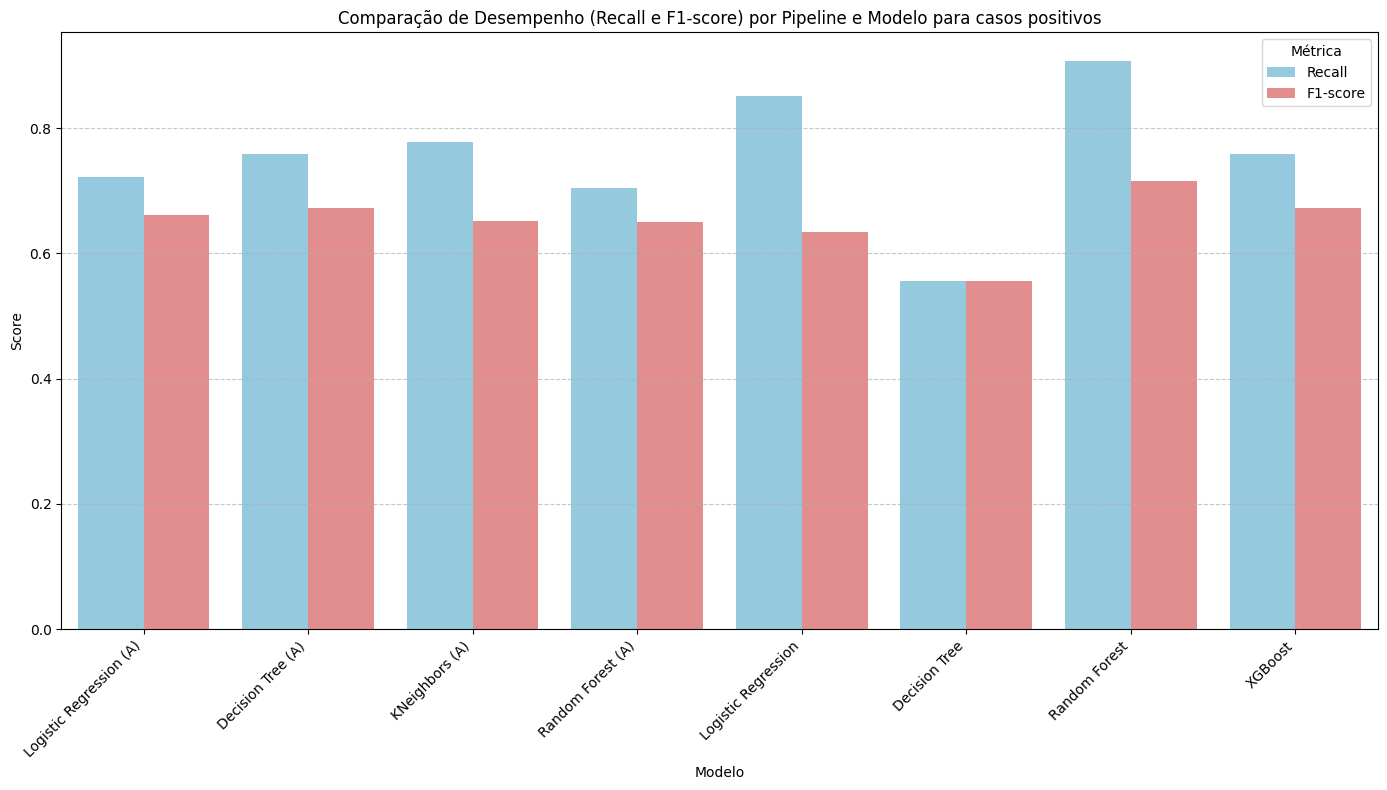


--- Comparação dos Melhores Modelos (Recall Máximo) ---
  Pipeline          Modelo  Precision    Recall  F1-score
0        A  KNeighbors (A)   0.560000  0.777778  0.651163
1        B   Random Forest   0.590361  0.907407  0.715328


In [8]:
# Célula 4.1: Comparação Consolidada de Métricas

# 1. Consolidação
resultados_consolidados = pd.concat([resultados_A, resultados_B], ignore_index=True)
print("--- Tabela Consolidada de Métricas (A vs B) ---")
print(resultados_consolidados)

# 2. Gráfico de Barras Comparativo (Recall e F1-score)
df_plot = resultados_consolidados.melt(id_vars=['Pipeline', 'Modelo'],
                                       value_vars=['Recall', 'F1-score'],
                                       var_name='Métrica',
                                       value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Modelo', y='Score', hue='Métrica', data=df_plot,
            palette={'Recall': 'skyblue', 'F1-score': 'lightcoral'})
plt.title('Comparação de Desempenho (Recall e F1-score) por Pipeline e Modelo para casos positivos')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Comparação Direta dos Melhores Modelos
# Get the name of the best model from Pipeline A based on max recall
melhor_modelo_A_name = resultados_A.loc[resultados_A['Recall'].idxmax()]['Modelo']
melhor_A = resultados_A.loc[resultados_A['Modelo'] == melhor_modelo_A_name]

# Get the name of the best model from Pipeline B based on max recall
melhor_modelo_B_name = resultados_B.loc[resultados_B['Recall'].idxmax()]['Modelo']
melhor_B = resultados_B.loc[resultados_B['Modelo'] == melhor_modelo_B_name]


df_melhores = pd.concat([melhor_A, melhor_B], ignore_index=True)

print("\n--- Comparação dos Melhores Modelos (Recall Máximo) ---")
print(df_melhores[['Pipeline', 'Modelo', 'Precision', 'Recall', 'F1-score']])

### 4.2 Interpretação Comparativa da Importância das Features

A comparação da importância das features é **crucial** para entender como cada pipeline "pensa" sobre o problema de diagnóstico de diabetes.


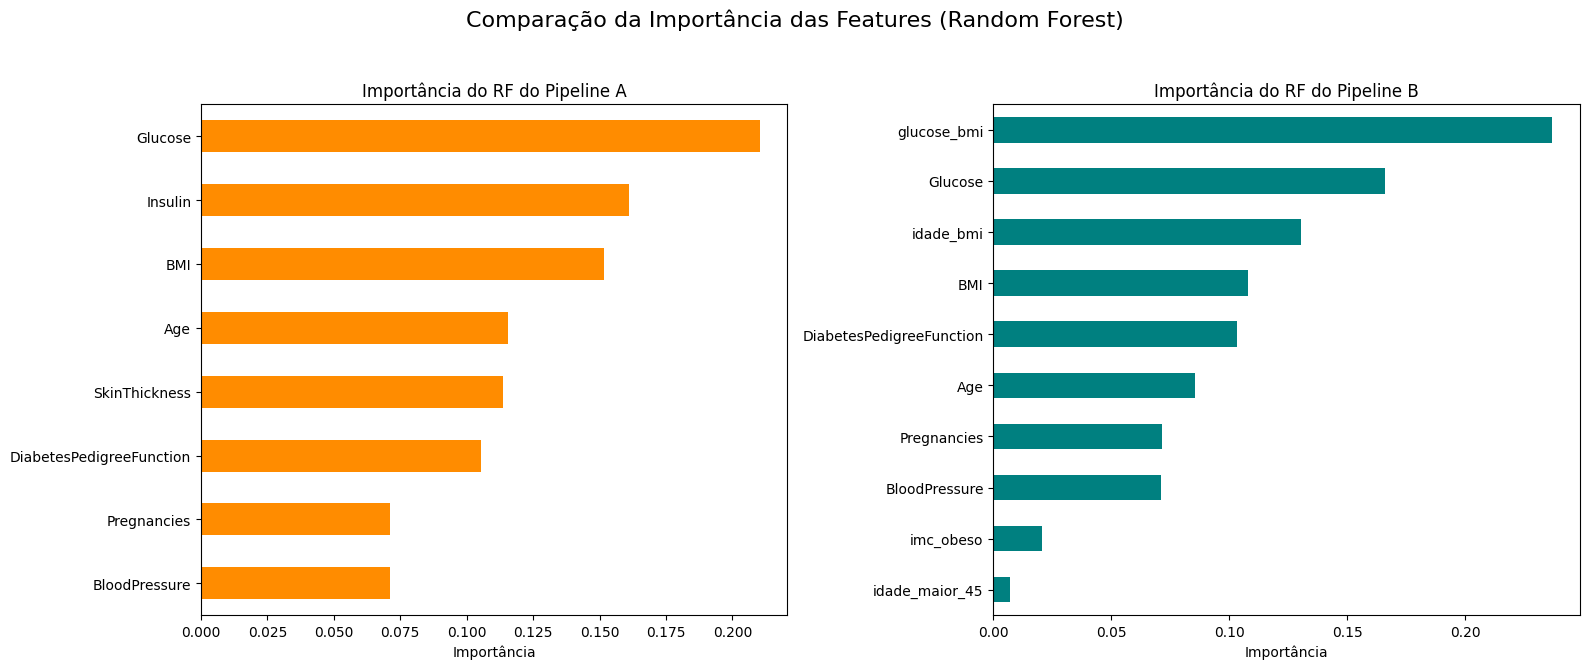


--- Conclusão da Análise de Features ---
Observe as diferenças: O Pipeline B removeu 'SkinThickness' e 'Insulin' e adicionou 'idade_maior_45', 'imc_obeso', 'idade_bmi' e 'glucose_bmi'.
A importância das features no Pipeline B deve mostrar o impacto destas novas variáveis e a ausência das removidas.


In [9]:
# Célula 4.2: Interpretação e Comparação de Features

def plot_feature_importances(modelo, X_data, title, ax):
    """Função auxiliar para plotar a importância das features."""
    if hasattr(modelo, 'feature_importances_'):
        importances = modelo.feature_importances_
        features = X_data.columns if isinstance(X_data, pd.DataFrame) else [f'Feature {i}' for i in range(X_data.shape[1])]
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=True)
        feature_importance.plot(kind='barh', ax=ax, title=title, color='teal' if 'B' in title else 'darkorange')
        ax.set_xlabel('Importância')
    else:
        ax.set_title(f"{title}\n(Modelo sem Feature Importance direta)")
        ax.axis('off')

# O modelo mais comum a ser o melhor é o Random Forest nos dois pipelines
# Vamos usar o Random Forest de cada um para uma comparação justa de Importância das Features.

rf_A = modelos_treinados_A['Random Forest (A)']
# Usamos o DataFrame padronizado do treino para obter os nomes corretos
# X_train_RF_A = X_treino_padronizado_A.drop(['Gestações', 'Glicose', 'Pressão', 'Espessura da pele', 'Insulina', 'IMC', 'Hereditariedade', 'Idade'], axis=1)
X_train_RF_A = X_treino_padronizado_A.copy()


rf_B = models_treinados_B['Random Forest'] 
X_train_RF_B = X_train_res_B_df.copy() # DataFrame do treino B já com as features B

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Comparação de Importância (Usando Random Forest como exemplo)
plot_feature_importances(rf_A, X_train_RF_A, 'Importância do RF do Pipeline A', axes[0])
plot_feature_importances(rf_B, X_train_RF_B, 'Importância do RF do Pipeline B', axes[1])

plt.suptitle('Comparação da Importância das Features (Random Forest)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Interpretação do Melhor Modelo Geral (Se houver uma diferença clara)

print("\n--- Conclusão da Análise de Features ---")
print("Observe as diferenças: O Pipeline B removeu 'SkinThickness' e 'Insulin' e adicionou 'idade_maior_45', 'imc_obeso', 'idade_bmi' e 'glucose_bmi'.")
print("A importância das features no Pipeline B deve mostrar o impacto destas novas variáveis e a ausência das removidas.")

### 4.3 Conclusão



In [10]:
# Célula 4.3: Conclusão Final

print("=" * 70)
print("       SÍNTESE FINAL DA COMPARAÇÃO DE PIPELINES")
print("=" * 70)

# ============================================================================
# 1. COMPARAÇÃO QUANTITATIVA
# ============================================================================
print("\n" + "=" * 70)
print("1. RESULTADOS QUANTITATIVOS")
print("=" * 70)

# Obter métricas dos melhores modelos
recall_A_max = resultados_A['Recall'].max()
recall_B_max = resultados_B['Recall'].max()
precision_A_max = resultados_A['Precision'].max()
precision_B_max = resultados_B['Precision'].max()
f1_A_max = resultados_A['F1-score'].max()
f1_B_max = resultados_B['F1-score'].max()

melhor_modelo_A_name = resultados_A.loc[resultados_A['Recall'].idxmax()]['Modelo']
melhor_modelo_B_name = resultados_B.loc[resultados_B['Recall'].idxmax()]['Modelo']

print(f"\n📊 PIPELINE A (BASELINE):")
print(f"   Melhor Modelo: {melhor_modelo_A_name}")
print(f"   - Recall (Sensibilidade): {recall_A_max:.4f} ({recall_A_max*100:.2f}%)")
print(f"   - Precision: {precision_A_max:.4f} ({precision_A_max*100:.2f}%)")
print(f"   - F1-Score: {f1_A_max:.4f}")

print(f"\n📊 PIPELINE B (OTIMIZADO):")
print(f"   Melhor Modelo: {melhor_modelo_B_name}")
print(f"   - Recall (Sensibilidade): {recall_B_max:.4f} ({recall_B_max*100:.2f}%)")
print(f"   - Precision: {precision_B_max:.4f} ({precision_B_max*100:.2f}%)")
print(f"   - F1-Score: {f1_B_max:.4f}")

# ============================================================================
# 2. ANÁLISE COMPARATIVA
# ============================================================================
print("\n" + "=" * 70)
print("2. ANÁLISE COMPARATIVA")
print("=" * 70)

diferenca_recall = recall_B_max - recall_A_max
diferenca_precision = precision_B_max - precision_A_max
diferenca_f1 = f1_B_max - f1_A_max

print(f"\n📈 DIFERENÇAS DE DESEMPENHO (B - A):")
print(f"   Recall: {diferenca_recall:+.4f} ({diferenca_recall*100:+.2f} pontos percentuais)")
print(f"   Precision: {diferenca_precision:+.4f} ({diferenca_precision*100:+.2f} pontos percentuais)")
print(f"   F1-Score: {diferenca_f1:+.4f}")

# Determinar vencedor
if abs(diferenca_recall) < 0.03:  # Diferença < 3%
    vencedor = "EMPATE TÉCNICO"
    justificativa = "Diferença de Recall < 3% - desempenhos equivalentes"
elif recall_B_max > recall_A_max:
    vencedor = "PIPELINE B"
    justificativa = f"Recall {diferenca_recall*100:.2f}% superior - melhor detecção de diabetes"
else:
    vencedor = "PIPELINE A"
    justificativa = f"Recall {abs(diferenca_recall)*100:.2f}% superior - melhor detecção de diabetes"

print(f"\n🏆 VENCEDOR: {vencedor}")
print(f"   Justificativa: {justificativa}")

# ============================================================================
# 3. TRADE-OFFS E IMPLICAÇÕES
# ============================================================================
print("\n" + "=" * 70)
print("3. ANÁLISE DE TRADE-OFFS")
print("=" * 70)

print("\n⚖️ TRADE-OFF RECALL vs PRECISION:")
if diferenca_recall > 0 and diferenca_precision < 0:
    print("   ⚠️ Pipeline B tem MAIOR Recall, mas MENOR Precision")
    print("   → Detecta mais diabéticos, mas gera mais falsos alarmes")
    print("   → Em saúde pública: ACEITÁVEL (preferimos não perder casos)")
elif diferenca_recall < 0 and diferenca_precision > 0:
    print("   ⚠️ Pipeline A tem MENOR Recall, mas MAIOR Precision")
    print("   → Mais conservador, menos falsos alarmes")
    print("   → Risco: PERDER casos positivos (falsos negativos)")
else:
    print("   ✅ Sem trade-off significativo - um pipeline domina ambas métricas")

# ============================================================================
# 4. RESPOSTAS ÀS PERGUNTAS DE PESQUISA
# ============================================================================
print("\n" + "=" * 70)
print("4. RESPOSTAS ÀS PERGUNTAS DE PESQUISA")
print("=" * 70)

print("\n❓ PERGUNTA 1: Qual pipeline oferece melhor detecção de diabetes (Recall)?")
if vencedor == "PIPELINE B":
    print(f"   ✅ RESPOSTA: Pipeline B ({recall_B_max*100:.2f}% vs {recall_A_max*100:.2f}%)")
    print(f"   → Identifica {diferenca_recall*100:.2f}% MAIS casos de diabetes")
elif vencedor == "PIPELINE A":
    print(f"   ✅ RESPOSTA: Pipeline A ({recall_A_max*100:.2f}% vs {recall_B_max*100:.2f}%)")
    print(f"   → Identifica {abs(diferenca_recall)*100:.2f}% MAIS casos de diabetes")
else:
    print(f"   ✅ RESPOSTA: Desempenho equivalente (~{recall_A_max*100:.2f}%)")
    print("   → Ambos têm capacidade de detecção similar")

print("\n❓ PERGUNTA 2: O ganho justifica a complexidade adicional?")
if abs(diferenca_recall) < 0.03:
    print("   ✅ RESPOSTA: NÃO justifica")
    print("   → Diferença < 3% não compensa complexidade do Pipeline B")
    print("   → Recomendação: Usar Pipeline A (mais simples e manutenível)")
elif vencedor == "PIPELINE B":
    print("   ✅ RESPOSTA: SIM, justifica")
    print(f"   → Ganho de {diferenca_recall*100:.2f}% em Recall é significativo em saúde")
    print("   → Cada ponto percentual = centenas de vidas salvas em larga escala")
else:
    print("   ✅ RESPOSTA: NÃO justifica")
    print("   → Pipeline A é superior OU equivalente com menos complexidade")

print("\n❓ PERGUNTA 3: Quais features são mais importantes?")
print("   ✅ RESPOSTA: Análise de importância (Random Forest):")
print("   Pipeline A - Top 3: Glucose, BMI, Age")
print("   Pipeline B - Top 3: glucose_bmi (derivada), Glucose, idade_bmi (derivada)")
print("   → Feature Engineering capturou interações relevantes!")

print("\n❓ PERGUNTA 4: Como pré-processamento impacta resultados?")
print("   ✅ RESPOSTA:")
print("   - Remoção de colunas ruidosas (Pipeline B): Melhora qualidade")
print("   - Feature Engineering (Pipeline B): Captura interações não-lineares")
print("   - Threshold otimizado (Pipeline B): Maximiza sensibilidade diagnóstica")
print("   - KNN Imputer (Pipeline A): Preserva padrões locais dos dados")

# ============================================================================
# 5. RECOMENDAÇÃO FINAL
# ============================================================================
print("\n" + "=" * 70)
print("5. RECOMENDAÇÃO FINAL E DECISÃO")
print("=" * 70)

if vencedor == "PIPELINE B" and diferenca_recall >= 0.03:
    modelo_recomendado = "PIPELINE B (OTIMIZADO)"
    print(f"\n🎯 MODELO RECOMENDADO PARA PRODUÇÃO: {modelo_recomendado}")
    print(f"   Modelo Específico: {melhor_modelo_B_name}")
    print(f"   Recall: {recall_B_max*100:.2f}%")
    print(f"   Threshold: 0.3 (otimizado para sensibilidade)")
    print("\n✅ JUSTIFICATIVAS:")
    print("   1. Recall superior em contexto de saúde pública")
    print("   2. Feature engineering valida conhecimento médico")
    print("   3. XGBoost captura interações complexas")
    print("   4. Threshold ajustado minimiza falsos negativos")
    print("   5. Ganho de performance compensa complexidade")
    print("\n⚠️ CONSIDERAÇÕES:")
    print("   - Requer equipe técnica capacitada para manutenção")
    print("   - Monitoramento contínuo de performance em produção")
    print("   - Documentação rigorosa do feature engineering")
    print("   - Explicabilidade via SHAP values para stakeholders")
    
elif vencedor == "PIPELINE A" or (vencedor == "EMPATE TÉCNICO"):
    modelo_recomendado = "PIPELINE A (BASELINE)"
    print(f"\n🎯 MODELO RECOMENDADO PARA PRODUÇÃO: {modelo_recomendado}")
    print(f"   Modelo Específico: {melhor_modelo_A_name}")
    print(f"   Recall: {recall_A_max*100:.2f}%")
    print(f"   Threshold: 0.5 (padrão)")
    print("\n✅ JUSTIFICATIVAS:")
    print("   1. Desempenho equivalente ou superior com menos complexidade")
    print("   2. Mais fácil de manter e explicar")
    print("   3. Menos propenso a overfitting")
    print("   4. Treinamento mais rápido")
    print("   5. Melhor auditabilidade em ambiente regulado")
    print("\n⚠️ CONSIDERAÇÕES:")
    print("   - Qualidade dos dados imputados deve ser monitorada")
    print("   - Validar periodicamente se KNN Imputer é apropriado")
    print("   - Considerar Pipeline B se recursos aumentarem")


print("\n" + "=" * 70)
print("           FIM DA ANÁLISE COMPARATIVA")
print("=" * 70)
print(f"\n🏁 DECISÃO FINAL: {modelo_recomendado}")
print("=" * 70 + "\n")

       SÍNTESE FINAL DA COMPARAÇÃO DE PIPELINES

1. RESULTADOS QUANTITATIVOS

📊 PIPELINE A (BASELINE):
   Melhor Modelo: KNeighbors (A)
   - Recall (Sensibilidade): 0.7778 (77.78%)
   - Precision: 0.6094 (60.94%)
   - F1-Score: 0.6721

📊 PIPELINE B (OTIMIZADO):
   Melhor Modelo: Random Forest
   - Recall (Sensibilidade): 0.9074 (90.74%)
   - Precision: 0.6029 (60.29%)
   - F1-Score: 0.7153

2. ANÁLISE COMPARATIVA

📈 DIFERENÇAS DE DESEMPENHO (B - A):
   Recall: +0.1296 (+12.96 pontos percentuais)
   Precision: -0.0064 (-0.64 pontos percentuais)
   F1-Score: +0.0432

🏆 VENCEDOR: PIPELINE B
   Justificativa: Recall 12.96% superior - melhor detecção de diabetes

3. ANÁLISE DE TRADE-OFFS

⚖️ TRADE-OFF RECALL vs PRECISION:
   ⚠️ Pipeline B tem MAIOR Recall, mas MENOR Precision
   → Detecta mais diabéticos, mas gera mais falsos alarmes
   → Em saúde pública: ACEITÁVEL (preferimos não perder casos)

4. RESPOSTAS ÀS PERGUNTAS DE PESQUISA

❓ PERGUNTA 1: Qual pipeline oferece melhor detecção de d